In [11]:
import pandas as pd
from cyvcf2 import VCF
import pysam
import re
import matplotlib.pyplot as plt

In [18]:
def prepare_vcf(vcf_path):
    """Prepare VCF file by sorting and indexing using pysam"""
    if not vcf_path.endswith('.gz'):
        print("Compressing VCF...")
        pysam.tabix_compress(vcf_path, f'{vcf_path}.gz')
        vcf_path = f'{vcf_path}.gz'
    
    print("Creating tabix index...")
    pysam.tabix_index(vcf_path, preset='vcf', force=True)
    
    return vcf_path

def filter_clinvar_vcf(vcf_path, output_path):
    """
    Filter ClinVar VCF file for immune-related variants.
    """
    # Prepare VCF first
    vcf_path = prepare_vcf(vcf_path)
    
    # Initialize VCF reader
    vcf = VCF(vcf_path)
    
    # Rest of your filtering code remains the same...
    immune_patterns = re.compile(
        r'immun|autoimmun|inflammation|lupus|arthritis|'
        r'thyroiditis|celiac|psoriasis|diabetes type 1|'
        r'multiple sclerosis|inflammatory bowel|'
        r'rheumatoid|vasculitis|myasthenia|'
        r'sarcoidosis|complement|HLA|cytokine',
        re.IGNORECASE
    )
    
    filtered_variants = []
    
    for variant in vcf:
        clndisdb = variant.INFO.get('CLNDISDB', '')
        clndn = variant.INFO.get('CLNDN', '')
        clnvc = variant.INFO.get('CLNVC', '')
        clnsig = variant.INFO.get('CLNSIG', '')
        
        searchable_text = f"{clndisdb} {clndn}"
        
        if immune_patterns.search(searchable_text):
            variant_info = {
                'chrom': variant.CHROM,
                'pos': variant.POS,
                'ref': variant.REF,
                'alt': ','.join(variant.ALT),
                'id': variant.ID,
                'disease_names': clndn,
                'variant_type': clnvc,
                'clinical_significance': clnsig
            }
            filtered_variants.append(variant_info)
    
    df = pd.DataFrame(filtered_variants)
    df.to_csv(output_path, index=False)
    
    # Print summary
    print(f"Found {len(df)} immune-related variants")
    print(f"\nMost common variant types:")
    print(df['variant_type'].value_counts().head())
    print(f"\nClinical significance distribution:")
    print(df['clinical_significance'].value_counts().head())
    
    return df

Creating tabix index...
Found 57110 immune-related variants

Most common variant types:
variant_type
single_nucleotide_variant    52267
Deletion                      2611
Duplication                   1055
Microsatellite                 657
Indel                          285
Name: count, dtype: int64

Clinical significance distribution:
clinical_significance
Uncertain_significance                          24131
Likely_benign                                   19855
Pathogenic                                       3404
Conflicting_classifications_of_pathogenicity     3283
Benign                                           2464
Name: count, dtype: int64

First few variants:


,chrom,pos,ref,alt,id,disease_names,variant_type,clinical_significance
0,1,1211567,C,T,641277,Combined_immunodeficiency_due_to_OX40_deficiency,single_nucleotide_variant,Uncertain_significance
1,1,1211573,G,A,1612262,Combined_immunodeficiency_due_to_OX40_deficiency,single_nucleotide_variant,Likely_benign
2,1,1211577,T,C,1367327,Combined_immunodeficiency_due_to_OX40_deficiency,single_nucleotide_variant,Uncertain_significance
3,1,1211580,G,T,2709476,Combined_immunodeficiency_due_to_OX40_deficiency,single_nucleotide_variant,Uncertain_significance
4,1,1211581,C,T,1446419,Combined_immunodeficiency_due_to_OX40_deficiency,single_nucleotide_variant,Uncertain_significance


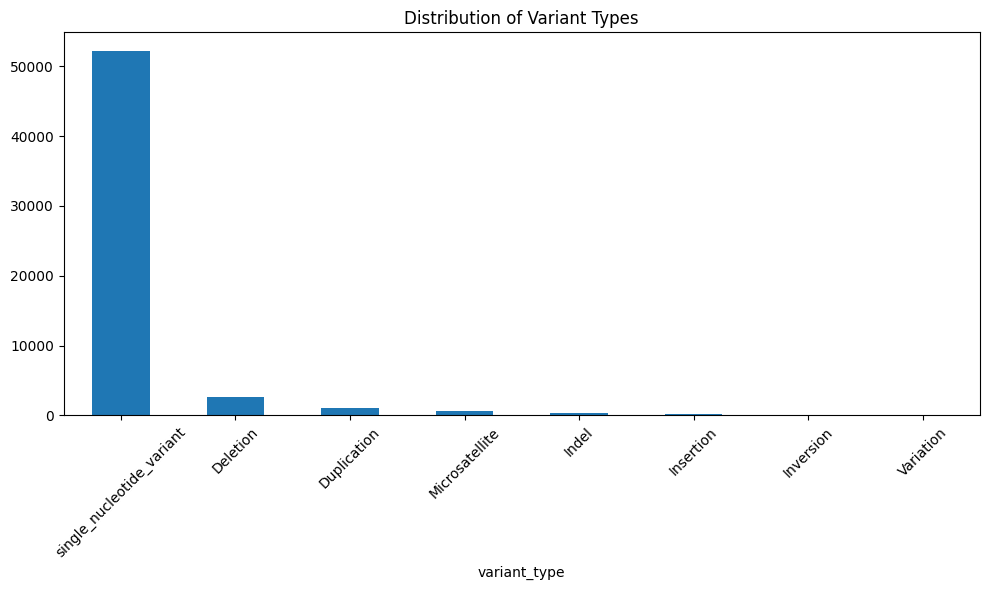

In [19]:
# Run the filtering
df = filter_clinvar_vcf("/Users/anonmacintosh/Downloads/clinvar.vcf.gz", "immune_variants.vcf")

# Examine results
print("\nFirst few variants:")
display(df.head())

plt.figure(figsize=(10, 6))
df['variant_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Variant Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()